# DKGPR

This notebook demonstrates how to use the DKGPR for:
1. Basic regression
2. Uncertainty quantification
3. Confidence weighting
4. Bayesian optimization

**Author:** Yongtao Liu 

**Date:** January 2026

## Installation

First, make sure the package is installed

In [1]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import torch

# Set style for better plots
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

In [2]:
# Import DKGP
from dkgp import fit_dkgp, predict
from dkgp.acquisition import (
    expected_improvement,
    upper_confidence_bound,
    probability_of_improvement
)
from dkgp.prediction import predict_with_epistemic_aleatoric
from dkgp.utils import (
    standardize_data,
    compute_metrics,
    compute_calibration,
    print_metrics
)

/Users/yla/ORNL Dropbox/Yongtao Liu/MyFiles/CNMS_2025/Githublocal/DKGP/.venv/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Basic Regression

Let's start with a simple regression problem on high-dimensional data.

### Generate Synthetic Data

In [3]:
def generate_data(n_samples=100, input_dim=50, noise=0.1):
    """
    Generate synthetic high-dimensional data.
    True function: non-linear combination of first few features
    """
    X = np.random.randn(n_samples, input_dim)
    
    # True underlying function (only first 5 features matter)
    y = (X[:, 0] + 
         2 * X[:, 1] - 
         X[:, 2] + 
         0.5 * X[:, 3]**2 + 
         np.sin(X[:, 4]) + 
         noise * np.random.randn(n_samples))
    
    return X, y

# Generate training data
X_train, y_train = generate_data(n_samples=200, input_dim=100, noise=0.1)

# Generate test data
X_test, y_test = generate_data(n_samples=50, input_dim=100, noise=0.1)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Target range: [{y_train.min():.2f}, {y_train.max():.2f}]")

Training set: (200, 100)
Test set: (50, 100)
Target range: [-5.93, 7.06]


### Train the Model

In [6]:
# Train Deep Kernel GP
mll, gp_model, dkl_model, losses = fit_dkgp(
    X_train,
    y_train,
    feature_dim=16,           # Reduce 100D -> 16D
    hidden_dims=[256, 128, 64],  # Neural network architecture
    num_epochs=3000,          # Training iterations
    lr_features=1e-4,         # Learning rate for neural network
    lr_gp=1e-4,              # Learning rate for GP
    verbose=True,
    plot_loss=False          # We'll plot manually
)

Training Deep Kernel GP Regression Model

Auto-selected: ExactMarginalLogLikelihood

Training Deep Kernel GP
  Device: cpu
  Input dim: 100 → Feature dim: 16
  Data points: 200
  Hidden layers: [256, 128, 64]
  MLL: ExactMarginalLogLikelihood
  Epoch  100/3000, Loss: 182.6953
  Epoch  200/3000, Loss: 167.2965
  Epoch  300/3000, Loss: 160.1766
  Epoch  400/3000, Loss: 158.1038
  Epoch  500/3000, Loss: 154.8634
  Epoch  600/3000, Loss: 152.9855
  Epoch  700/3000, Loss: 150.8935
  Epoch  800/3000, Loss: 150.2136
  Epoch  900/3000, Loss: 149.0742
  Epoch 1000/3000, Loss: 148.7853
  Epoch 1100/3000, Loss: 147.1221
  Epoch 1200/3000, Loss: 146.4123
  Epoch 1300/3000, Loss: 145.2353
  Epoch 1400/3000, Loss: 144.5319
  Epoch 1500/3000, Loss: 143.8344
  Epoch 1600/3000, Loss: 142.8053
  Epoch 1700/3000, Loss: 142.1676
  Epoch 1800/3000, Loss: 141.1592
  Epoch 1900/3000, Loss: 140.4413
  Epoch 2000/3000, Loss: 139.6004
  Epoch 2100/3000, Loss: 138.7343
  Epoch 2200/3000, Loss: 137.9656
  Epoch 2

### Visualize Training Progress

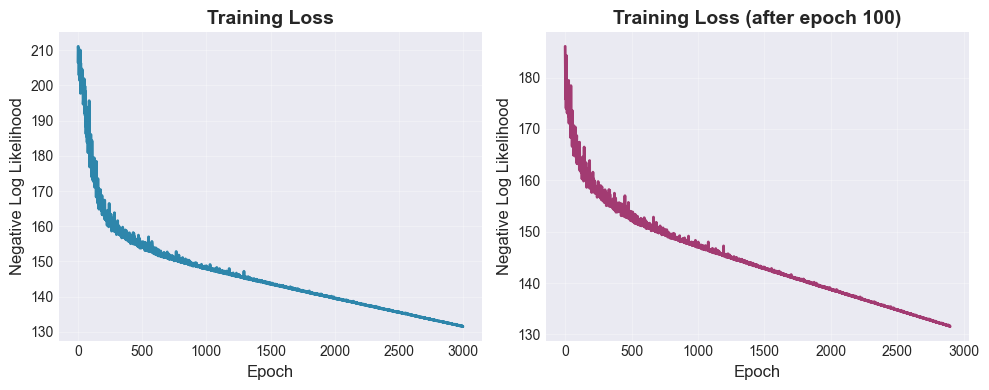

Final loss: 131.5194


In [7]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(losses, linewidth=2, color='#2E86AB')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Negative Log Likelihood', fontsize=12)
plt.title('Training Loss', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(losses[100:], linewidth=2, color='#A23B72')  # Skip first 100 epochs
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Negative Log Likelihood', fontsize=12)
plt.title('Training Loss (after epoch 100)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Final loss: {losses[-1]:.4f}")

### Make Predictions

In [8]:
# Predict on test set
mean_pred, std_pred = predict(dkl_model, X_test, return_std=True)

print(f"Predictions shape: {mean_pred.shape}")
print(f"Uncertainty shape: {std_pred.shape}")
print(f"Mean uncertainty: {std_pred.mean():.4f}")

RuntimeError: Flattening the training labels failed. The most common cause of this error is that the shapes of the prior mean and the training labels are mismatched. The shape of the train targets is torch.Size([200, 1]), while the reported shape of the mean is torch.Size([200]).

### Evaluate Performance

In [ ]:
# Compute metrics
metrics = compute_metrics(y_test, mean_pred, std_pred)
print_metrics(metrics, "Test Set Performance")

### Visualize Predictions

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# 1. Predictions vs True
axes[0].scatter(y_test, mean_pred, alpha=0.6, s=80, edgecolors='k', linewidth=1)
min_val = min(y_test.min(), mean_pred.min())
max_val = max(y_test.max(), mean_pred.max())
axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect')
axes[0].set_xlabel('True Values', fontsize=12)
axes[0].set_ylabel('Predicted Values', fontsize=12)
axes[0].set_title(f'Predictions (R²={metrics["r2"]:.3f})', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. Residuals
residuals = y_test - mean_pred
axes[1].scatter(mean_pred, residuals, alpha=0.6, s=80, edgecolors='k', linewidth=1)
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Values', fontsize=12)
axes[1].set_ylabel('Residuals', fontsize=12)
axes[1].set_title('Residual Plot', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# 3. Predictions with uncertainty
sorted_idx = np.argsort(y_test)
x_axis = np.arange(len(y_test))

axes[2].plot(x_axis, y_test[sorted_idx], 'o-', label='True', linewidth=2, markersize=7)
axes[2].plot(x_axis, mean_pred[sorted_idx], 's-', label='Predicted', linewidth=2, markersize=7)
axes[2].fill_between(
    x_axis,
    mean_pred[sorted_idx] - 2*std_pred[sorted_idx],
    mean_pred[sorted_idx] + 2*std_pred[sorted_idx],
    alpha=0.3,
    label='95% CI'
)
axes[2].set_xlabel('Test Sample (sorted)', fontsize=12)
axes[2].set_ylabel('Value', fontsize=12)
axes[2].set_title('Predictions with Uncertainty', fontsize=13, fontweight='bold')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
## 2️⃣ Uncertainty Quantification

Deep Kernel GP provides two types of uncertainty:
- **Epistemic**: Model uncertainty (reducible with more data)
- **Aleatoric**: Observation noise (irreducible)

In [ ]:
# Decompose uncertainty
mean_unc, epistemic, aleatoric, total = predict_with_epistemic_aleatoric(
    dkl_model, X_test
)

# Convert to std (from variance)
epistemic_std = np.sqrt(epistemic)
aleatoric_std = np.sqrt(aleatoric)
total_std = np.sqrt(total)

print("Uncertainty Decomposition:")
print(f"  Epistemic (model):      {epistemic_std.mean():.4f} ± {epistemic_std.std():.4f}")
print(f"  Aleatoric (noise):      {aleatoric_std.mean():.4f} ± {aleatoric_std.std():.4f}")
print(f"  Total:                  {total_std.mean():.4f} ± {total_std.std():.4f}")
print(f"  Epistemic/Aleatoric:    {epistemic_std.mean()/aleatoric_std.mean():.2f}")

In [ ]:
# Visualize uncertainty decomposition
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Stacked bar chart
x_axis = np.arange(len(y_test))
axes[0].bar(x_axis, epistemic_std, label='Epistemic', alpha=0.8, color='#F18F01')
axes[0].bar(x_axis, aleatoric_std, bottom=epistemic_std, label='Aleatoric', alpha=0.8, color='#C73E1D')
axes[0].set_xlabel('Test Sample', fontsize=12)
axes[0].set_ylabel('Uncertainty (std)', fontsize=12)
axes[0].set_title('Uncertainty Decomposition', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Scatter plot
axes[1].scatter(epistemic_std, aleatoric_std, alpha=0.6, s=80, edgecolors='k', linewidth=1)
axes[1].set_xlabel('Epistemic Uncertainty', fontsize=12)
axes[1].set_ylabel('Aleatoric Uncertainty', fontsize=12)
axes[1].set_title('Epistemic vs Aleatoric', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Calibration Analysis

Check if our uncertainty estimates are well-calibrated.

In [ ]:
# Compute calibration
calibration = compute_calibration(y_test, mean_pred, std_pred, n_bins=10)

print(f"Mean Absolute Calibration Error: {calibration['mace']:.4f}")
print("(Lower is better, 0 = perfect calibration)")

In [ ]:
# Plot calibration curve
plt.figure(figsize=(7, 7))

conf = calibration['confidence_levels']
obs = calibration['observed_coverage']

plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Perfect Calibration')
plt.plot(conf, obs, 'o-', linewidth=3, markersize=10, color='#2E86AB', label='Model')

plt.xlabel('Expected Coverage', fontsize=13)
plt.ylabel('Observed Coverage', fontsize=13)
plt.title(f'Calibration Curve\n(MACE = {calibration["mace"]:.4f})', 
          fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---
## 3️⃣ Confidence Weighting

Sometimes data points have different reliability. We can weight them accordingly.

### Generate Data with Varying Noise

In [ ]:
# Generate data with heteroscedastic noise
n_train = 150
X_noisy = np.random.randn(n_train, 50)

# True function
y_true = X_noisy[:, 0] + 2*X_noisy[:, 1] + np.sin(X_noisy[:, 2])

# Noise level varies with input
noise_level = 0.1 + 0.5 * np.abs(X_noisy[:, 0])  # Higher noise for larger |x[0]|
y_noisy = y_true + noise_level * np.random.randn(n_train)

print(f"Noise level range: [{noise_level.min():.3f}, {noise_level.max():.3f}]")

In [ ]:
# Visualize noise distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.scatter(X_noisy[:, 0], y_noisy, c=noise_level, s=50, cmap='YlOrRd', edgecolors='k', linewidth=0.5)
plt.colorbar(label='Noise Level')
plt.xlabel('X[0]', fontsize=12)
plt.ylabel('Y (with noise)', fontsize=12)
plt.title('Data with Varying Noise', fontsize=13, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(noise_level, bins=20, edgecolor='k', alpha=0.7, color='#A23B72')
plt.xlabel('Noise Level', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Noise Distribution', fontsize=13, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

### Train with Confidence Weights

In [ ]:
# Compute confidence weights (inverse of noise level)
# Lower noise -> Higher confidence
confidence = 1.0 / (1.0 + noise_level**2)

print(f"Confidence range: [{confidence.min():.3f}, {confidence.max():.3f}]")
print(f"High noise -> Low confidence: {confidence[noise_level > 0.4].mean():.3f}")
print(f"Low noise -> High confidence: {confidence[noise_level < 0.2].mean():.3f}")

In [ ]:
# Train WITHOUT confidence weights
print("Training WITHOUT confidence weighting...")
_, _, model_no_weight, _ = fit_dkgp(
    X_noisy, y_noisy,
    feature_dim=16,
    num_epochs=800,
    verbose=False
)

# Train WITH confidence weights
print("Training WITH confidence weighting...")
_, _, model_weighted, _ = fit_dkgp(
    X_noisy, y_noisy,
    confidence_weights=confidence,
    feature_dim=16,
    num_epochs=800,
    verbose=False
)

print("✅ Both models trained!")

### Compare Performance

In [ ]:
# Generate clean test data
X_test_clean = np.random.randn(50, 50)
y_test_clean = X_test_clean[:, 0] + 2*X_test_clean[:, 1] + np.sin(X_test_clean[:, 2])

# Predictions
pred_no_weight, _ = predict(model_no_weight, X_test_clean)
pred_weighted, _ = predict(model_weighted, X_test_clean)

# Compute errors
mse_no_weight = np.mean((y_test_clean - pred_no_weight)**2)
mse_weighted = np.mean((y_test_clean - pred_weighted)**2)

print("Test Set Performance:")
print(f"  Without weighting: MSE = {mse_no_weight:.4f}")
print(f"  With weighting:    MSE = {mse_weighted:.4f}")
print(f"  Improvement:       {(1 - mse_weighted/mse_no_weight)*100:.1f}%")

In [ ]:
# Visualize comparison
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test_clean, pred_no_weight, alpha=0.6, s=80, label='Without Weighting')
plt.scatter(y_test_clean, pred_weighted, alpha=0.6, s=80, label='With Weighting')
min_val = y_test_clean.min()
max_val = y_test_clean.max()
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect')
plt.xlabel('True Values', fontsize=12)
plt.ylabel('Predicted Values', fontsize=12)
plt.title('Predictions: Weighted vs Unweighted', fontsize=13, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
errors_no_weight = np.abs(y_test_clean - pred_no_weight)
errors_weighted = np.abs(y_test_clean - pred_weighted)
x = np.arange(len(y_test_clean))
width = 0.35
plt.bar(x - width/2, errors_no_weight, width, label='Without Weighting', alpha=0.8)
plt.bar(x + width/2, errors_weighted, width, label='With Weighting', alpha=0.8)
plt.xlabel('Test Sample', fontsize=12)
plt.ylabel('Absolute Error', fontsize=12)
plt.title('Error Comparison', fontsize=13, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

---
## 4️⃣ Bayesian Optimization

Use Deep Kernel GP to optimize an expensive black-box function.

### Define Test Function

In [ ]:
def branin_high_dim(x):
    """
    Branin function (classic optimization benchmark) in high dimensions.
    Only first 2 dimensions matter, rest are noise.
    Global minimum ≈ 0.398 at (π, 2.275) and two other locations.
    """
    x1 = x[0] * 15 - 5   # Scale to [-5, 10]
    x2 = x[1] * 15        # Scale to [0, 15]
    
    a = 1
    b = 5.1 / (4 * np.pi**2)
    c = 5 / np.pi
    r = 6
    s = 10
    t = 1 / (8 * np.pi)
    
    term1 = a * (x2 - b * x1**2 + c * x1 - r)**2
    term2 = s * (1 - t) * np.cos(x1)
    term3 = s
    
    # Add small noise from other dimensions
    if len(x) > 2:
        noise = 0.05 * np.sum(x[2:]**2)
    else:
        noise = 0
    
    return term1 + term2 + term3 + noise

print(f"True global minimum: ≈ 0.398")
print(f"Test evaluation: {branin_high_dim(np.array([0.5424, 0.1517] + [0]*18)):.4f}")

### Initialize with Random Samples

In [ ]:
# Problem setup
input_dim = 20
n_initial = 10
n_iterations = 15

# Generate candidate pool
n_candidates = 2000
candidates = np.random.uniform(0, 1, size=(n_candidates, input_dim))

# Initial random samples
initial_idx = np.random.choice(n_candidates, n_initial, replace=False)
X_observed = candidates[initial_idx]
y_observed = np.array([branin_high_dim(x) for x in X_observed])

print(f"Initial samples: {n_initial}")
print(f"Initial best: {y_observed.min():.4f}")
print(f"Candidate pool: {n_candidates} points")

### Run Bayesian Optimization Loop

In [ ]:
# Track progress
best_values = [y_observed.min()]
all_values = list(y_observed)
ei_values_history = []

print("Starting Bayesian Optimization...\n")
print(f"{'Iter':<6} {'Next f(x)':<12} {'Best f(x)':<12} {'Max EI':<12}")
print("="*48)

for iteration in range(n_iterations):
    # Train model on current observations
    _, _, model, _ = fit_dkgp(
        X_observed,
        y_observed,
        feature_dim=16,
        num_epochs=500,
        verbose=False
    )
    
    # Get current best
    best_f = y_observed.min()
    
    # Remove already evaluated candidates
    mask = np.ones(len(candidates), dtype=bool)
    for x in X_observed:
        mask &= ~np.all(np.isclose(candidates, x), axis=1)
    available = candidates[mask]
    
    # Compute Expected Improvement
    ei = expected_improvement(
        model,
        available,
        best_f=best_f,
        xi=0.01,
        maximize=False  # Minimize Branin
    )
    
    # Select next point
    next_idx = np.argmax(ei)
    next_point = available[next_idx]
    next_value = branin_high_dim(next_point)
    
    # Update observations
    X_observed = np.vstack([X_observed, next_point])
    y_observed = np.append(y_observed, next_value)
    
    # Track progress
    best_values.append(y_observed.min())
    all_values.append(next_value)
    ei_values_history.append(ei.max())
    
    print(f"{iteration+1:<6} {next_value:<12.4f} {y_observed.min():<12.4f} {ei.max():<12.6f}")

print("="*48)
print(f"\nOptimization complete!")
print(f"Final best value: {y_observed.min():.4f}")
print(f"True global minimum: 0.398")
print(f"Gap: {y_observed.min() - 0.398:.4f}")

### Visualize Optimization Progress

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Best value over iterations
axes[0, 0].plot(best_values, 'o-', linewidth=2, markersize=8, color='#2E86AB')
axes[0, 0].axhline(y=0.398, color='r', linestyle='--', linewidth=2, label='Global minimum')
axes[0, 0].set_xlabel('Iteration', fontsize=12)
axes[0, 0].set_ylabel('Best f(x) Found', fontsize=12)
axes[0, 0].set_title('Optimization Progress', fontsize=13, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. All evaluations
axes[0, 1].plot(all_values, 'o', alpha=0.6, markersize=6, color='#A23B72')
axes[0, 1].axhline(y=0.398, color='r', linestyle='--', linewidth=2, label='Global minimum')
axes[0, 1].axvline(x=n_initial-0.5, color='k', linestyle=':', linewidth=2, label='Initial samples')
axes[0, 1].set_xlabel('Evaluation', fontsize=12)
axes[0, 1].set_ylabel('f(x)', fontsize=12)
axes[0, 1].set_title('All Evaluations', fontsize=13, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Expected Improvement over iterations
axes[1, 0].plot(ei_values_history, 's-', linewidth=2, markersize=7, color='#F18F01')
axes[1, 0].set_xlabel('Iteration', fontsize=12)
axes[1, 0].set_ylabel('Max Expected Improvement', fontsize=12)
axes[1, 0].set_title('Acquisition Function Values', fontsize=13, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# 4. Cumulative improvement
improvements = np.maximum.accumulate(-np.array(best_values))  # Negative for minimization
axes[1, 1].plot(improvements, 'o-', linewidth=2, markersize=8, color='#C73E1D')
axes[1, 1].set_xlabel('Iteration', fontsize=12)
axes[1, 1].set_ylabel('Cumulative Improvement', fontsize=12)
axes[1, 1].set_title('Total Improvement Over Initial Best', fontsize=13, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Compare Acquisition Functions

In [ ]:
# Train final model
_, _, final_model, _ = fit_dkgp(
    X_observed, y_observed,
    feature_dim=16,
    num_epochs=500,
    verbose=False
)

# Sample some test candidates
test_candidates = np.random.uniform(0, 1, (100, input_dim))
best_f = y_observed.min()

# Compute different acquisition functions
ei = expected_improvement(final_model, test_candidates, best_f, maximize=False)
ucb = upper_confidence_bound(final_model, test_candidates, beta=2.0, maximize=False)
pi = probability_of_improvement(final_model, test_candidates, best_f, maximize=False)

# Normalize for comparison
ei_norm = (ei - ei.min()) / (ei.max() - ei.min() + 1e-8)
ucb_norm = (ucb - ucb.min()) / (ucb.max() - ucb.min() + 1e-8)
pi_norm = (pi - pi.min()) / (pi.max() - pi.min() + 1e-8)

# Plot
plt.figure(figsize=(12, 4))

x = np.arange(len(test_candidates))
width = 0.25

plt.bar(x - width, ei_norm, width, label='EI', alpha=0.8)
plt.bar(x, ucb_norm, width, label='UCB', alpha=0.8)
plt.bar(x + width, pi_norm, width, label='PI', alpha=0.8)

plt.xlabel('Candidate Index', fontsize=12)
plt.ylabel('Normalized Acquisition Value', fontsize=12)
plt.title('Comparison of Acquisition Functions', fontsize=13, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# Show top candidates for each
print("\nTop 3 candidates by acquisition function:")
print(f"  EI:  indices {np.argsort(ei)[-3:][::-1]}")
print(f"  UCB: indices {np.argsort(ucb)[:3]}")
print(f"  PI:  indices {np.argsort(pi)[-3:][::-1]}")

---
## 📚 Summary

In this notebook, we covered:

1. ✅ **Basic Regression**: Training on high-dimensional data
2. ✅ **Uncertainty Quantification**: Epistemic vs aleatoric uncertainty
3. ✅ **Confidence Weighting**: Handling varying data quality
4. ✅ **Bayesian Optimization**: Using acquisition functions

### Key Takeaways

- Deep Kernel GP combines neural networks with GPs for high-dimensional regression
- Provides well-calibrated uncertainty estimates
- Confidence weighting improves performance on noisy data
- Multiple acquisition functions available for Bayesian optimization

### Next Steps

- Try on your own dataset
- Experiment with different architectures (`feature_dim`, `hidden_dims`)
- Compare acquisition functions on your optimization problem
- Save/load models with `utils.save_model()` and `utils.load_model()`

Happy modeling! 🚀